In [1]:
import pandas as pd
import numpy as np

data2019 = pd.read_csv("./FullData2019.csv")
data2019 = data2019.drop_duplicates('hhid').reset_index(drop=True)
data2016 = pd.read_csv("./FullData2016.csv")
def FCSStaus(val):
    if val <=21:
        return 1
    else:
        return 0
# create the binary food insecurity indicator
data2019['FCSStaus'] = data2019['FCS'].apply(FCSStaus)
data2016['FCSStaus'] = data2016['FCS'].apply(FCSStaus)
# create a lagged FCS
data2016['dismerge'] = data2016['s1aq2a'].str.upper()
mg2016 = data2016[['FCSStaus','dismerge']].groupby('dismerge').mean().reset_index()
mg2016.rename(columns={'dismerge':'s1aq2a', 'FCSStaus':'FCSStaus_lag'}, inplace=True)
data2019['FCSStaus_lag'] = pd.merge(data2019, mg2016, on='s1aq2a', how='left')['FCSStaus_lag']

# imputation for NA, with mode  
individual = ['HouseType', 'RoofType', 'WaterSource',
       'DistDrinkingWater', 'ShareToilet', 'Income', 'Kind Income Ratio', 'Salt', 'SubjectivePoverty', 'RelLivStandard',
       'IncomeStab', 'LivStandChange','MaleRatio', 'AvgAge', 'SelfArg', 'SelfHerd',
       'OwnNow_ArgLand', 'valueNow_ArgLand', 'Own1yrAgo_ArgLand',
       'ValueAgo_ArgLand', 'OwnNow_TV', 'valueNow_TV', 'Own1yrAgo_TV',
       'ValueAgo_TV', 'OwnNow_FixPhone', 'valueNow_FixPhone',
       'Own1yrAgo_FixPhone', 'ValueAgo_FixPhone', 'OwnNow_MobilePhone',
       'valueNow_MobilePhone', 'Own1yrAgo_MobilePhone', 'ValueAgo_MobilePhone','OwnNow_Refrigerator', 'valueNow_Refrigerator',
       'Own1yrAgo_Refrigerator', 'ValueAgo_Refrigerator', 'OwnNow_Furniture',
       'valueNow_Furniture', 'Own1yrAgo_Furniture', 'ValueAgo_Furniture','OwnNow_Cooker', 'valueNow_Cooker', 'Own1yrAgo_Cooker',
       'ValueAgo_Cooker', 'OwnNow_Livestock', 'valueNow_Livestock','Own1yrAgo_Livestock', 'ValueAgo_Livestock','valueNowTotal',
       'ValueAgoTotal','FamilySize','SelfStapleTypes','FCSStaus_lag'] # ShareToilet and Salt are dummies 

for i in individual: 
    # data2016[i].fillna(data2016[i].mode()[0],inplace=True)
    data2019[i].fillna(data2019[i].mode()[0],inplace=True)
# wkd2016 = pd.get_dummies(data2016,columns=["ShareToilet","Salt"])
wkd2019 = pd.get_dummies(data2019,columns=["ShareToilet","Salt"])
wkd2019_2 = pd.get_dummies(wkd2019,columns=["IncomeStab",'SubjectivePoverty', 'RelLivStandard','LivStandChange'])
# frequency encoding 
# freq = ['HouseType', 'RoofType', 'WaterSource',
#        'DistDrinkingWater', 'SubjectivePoverty', 'RelLivStandard',
#        'IncomeStab', 'LivStandChange']
freq = ['HouseType', 'RoofType', 'WaterSource']

wkd2019_2['DistDrinkingWaterBig3'] = wkd2019_2['DistDrinkingWater'].replace({'0-3':0, "3-5":1, "5-8":1,'8 or more KMs':1 })
# for i in freq: 
#     freqf = data2016.groupby(i).size()/len(data2016)
#     wkd2016[f"{i}_feq"] = wkd2016[i].apply(lambda x : freqf[x])
for j in freq: 
    freqf = wkd2019_2.groupby(j).size()/len(wkd2019_2)
    wkd2019_2[f"{j}_feq"] = wkd2019_2[j].apply(lambda x : freqf[x])
    
wkd2019_2['fatalitiesMean'] = wkd2019_2[['fatalities', 'fatalities lag1', 'fatalities lag2', 'fatalities lag3',
       'fatalities lag4']].sum(axis=1)
wkd2019_2['temperatureMean'] = wkd2019_2[['temperature', 'temperature lag1',
       'temperature lag2', 'temperature lag3', 'temperature lag4']].mean(axis=1)
wkd2019_2['precipitationMean'] = wkd2019_2[['precipitation', 'precipitation lag1', 'precipitation lag2',
       'precipitation lag3', 'precipitation lag4']].mean(axis=1)
wkd2019_2['NDVIMean'] = wkd2019_2[['NDVI', 'NDVI lag1', 'NDVI lag2', 'NDVI lag3', 'NDVI lag4']].mean(axis=1)
wkd2019_2['NDVI Anomaly Mean'] = wkd2019_2[['NDVI Anomaly',
       'NDVI Anomaly lag1', 'NDVI Anomaly lag2', 'NDVI Anomaly lag3',
       'NDVI Anomaly lag4']].mean(axis=1)

# feature engineering 
value_list = ['valueNow_ArgLand', "Income", 
       'valueNow_TV', 'valueNow_FixPhone',  'valueNow_MobilePhone', 'valueNow_Refrigerator', 'valueNow_Furniture', 
       'valueNow_Cooker', 'valueNow_Livestock', 'valueNowTotal', 'ValueAgoTotal']
value_list_new = [f'{i}_new' for i in value_list]
wkd2019_2[value_list_new] = np.log(wkd2019_2[value_list] + 1)*10
wkd2019_2['FamilySize_new'] =  np.log(wkd2019_2['FamilySize'])*10
wkd2019_2['SelfStapleTypes_new'] =  np.log(wkd2019_2['SelfStapleTypes'] + 1)*10

macrologList = ['NL_District', 'NL_County', 'fatalitiesMean', 'temperatureMean',
       'precipitationMean', 'NDVIMean', 'NDVI Anomaly Mean', 'Kind Income Ratio', 
       'Average (mm)', '1 Month Anomaly (%)', '3 Months Anomaly (%)','MaleRatio', 'AvgAge' ]
macrologList_new = [f'{i}_log' for i in macrologList]
wkd2019_2[macrologList_new] = np.log(wkd2019_2[macrologList]+1)*10

time_splitted_data_1920 = { }

for y in [2019, 2020]:
    for m in range(1,13):
        if wkd2019_2.query("year == @y and month == @m").shape[0] != 0: 
            time_splitted_data_1920[f"{y}_{m}"] = wkd2019_2.query("year == @y and month == @m").reset_index(drop = True)
        else: 
            continue 

In [3]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
import shap
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import  make_scorer
import matplotlib.pyplot as plt
from sklearn import metrics
from python_functions.modues import StandardizerTrainTest, resampling, XGBmodelfit, XGBmodelfitTime, timeplot
from python_functions.modues import _Flexible_test_prediction, Metrics_TradeOff_Plot, variable_distribution_crosscheck
import seaborn as sns

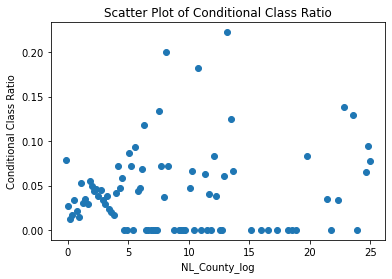

In [4]:
import numpy as np
import matplotlib.pyplot as plt

varname = 'NL_County_log'
variable_distribution_crosscheck(varname, wkd2019_2)

In [5]:
predictorList = ['FCSStaus_lag', 'urban','NL_District_log', 
       'precipitationMean', 'NDVI Anomaly Mean',
       'Average (mm)',  '1 Month Anomaly (%)', '3 Months Anomaly (%)', 
       'fatalitiesMean_log','temperatureMean_log','NDVIMean_log',
       'Kind Income Ratio','MaleRatio', 'AvgAge', 'SelfArg', 'SelfHerd', 'ShareToilet_Yes', 'Salt_Yes',
       'HouseType_feq', 'RoofType_feq', 'WaterSource_feq', 'IncomeStab_Somewhat stable',
       'IncomeStab_Very unstable',
       'SubjectivePoverty_Neither poor nor rich', 'SubjectivePoverty_Poor',
       'SubjectivePoverty_Very poor', 'RelLivStandard_Better off',
       'RelLivStandard_Same', 'RelLivStandard_Worse off',
       'LivStandChange_Decreased', 'LivStandChange_Increased',
       'LivStandChange_Stayed at the same', 'DistDrinkingWaterBig3', 'FamilySize', 
       'SelfStapleTypes', 'valueNow_MobilePhone', 'valueNowTotal', 'valueNow_Furniture', 
        'valueNow_MobilePhone_new', 'valueNow_ArgLand_new', 'valueNow_ArgLand', 'valueNow_Livestock', 
       'valueNow_Furniture_new', 'valueNow_Livestock_new', 'valueNowTotal_new', 'Income_new', 'Income', 
       'ValueAgoTotal_new', 'valueNow_FixPhone',  
       'valueNow_Refrigerator']

binaryList = ['urban','Salt_Yes','ShareToilet_Yes','SelfArg', 'SelfHerd', 'IncomeStab_Somewhat stable',
       'IncomeStab_Very unstable','SubjectivePoverty_Neither poor nor rich', 'SubjectivePoverty_Poor',
       'SubjectivePoverty_Very poor', 'RelLivStandard_Better off',
       'RelLivStandard_Same', 'RelLivStandard_Worse off',
       'LivStandChange_Decreased', 'LivStandChange_Increased', 
       'LivStandChange_Stayed at the same','DistDrinkingWaterBig3']

freqList = [f"{i}_feq" for i in freq]

# nonstdList = ['valueNow_ArgLand_new', 'valueNow_TV_new', 'valueNow_FixPhone_new',
#        'valueNow_MobilePhone_new', 'valueNow_Refrigerator_new',
#        'valueNow_Furniture_new', 'valueNow_Cooker_new',
#        'valueNow_Livestock_new', 'valueNowTotal_new', 'FamilySize_new',
#        'SelfStapleTypes_new']

nonstdList = []

standardizationList = list(set(predictorList) - set(binaryList) - set(freqList) - set(nonstdList))

In [6]:
sum(wkd2019_2[predictorList].isna().sum(axis=0))

0

#### Time

In [7]:
time_splitted_data_1920.keys()

dict_keys(['2019_9', '2019_10', '2019_11', '2019_12', '2020_1', '2020_2', '2020_7', '2020_8', '2020_9', '2020_10', '2020_11'])

In [8]:

date19List = [i for i in time_splitted_data_1920.keys()]
data19List = [i for i in time_splitted_data_1920.values()]

# here we generate the "time series" train and test data, we use the first 4 months in 19/20 data as the first set
# of training data, and then add one month in each round, the test data is the next month of the last train data 
trainDataStart = data19List[0].copy()

for i in range(1, 3):
    interTrainData = data19List[i].copy()
    trainDataStart = pd.concat([trainDataStart, interTrainData], axis=0)
    
trainData = {"train_2":trainDataStart.reset_index(drop = True)}
testData = {"test_2":data19List[3].reset_index(drop = True)}

for i in range(3, len(time_splitted_data_1920.keys()) - 1):
    interTrainData = pd.concat([trainData[f"train_{i - 1}"], data19List[i].copy()], axis=0)
    interTestData = data19List[i + 1].copy()
    trainData[f"train_{i}"] = interTrainData.reset_index(drop = True)
    testData[f"test_{i}"] = interTestData.reset_index(drop = True)
# standardize and resample 
StdTrain = {}
StdTest = {}
train19List = [i for i in trainData.values()]
test19List = [i for i in testData.values()]

for train, test, name1, name2 in zip(train19List, test19List,  trainData.keys(), testData.keys()):
    standardizedTrain, standardizedTest = StandardizerTrainTest(train[predictorList], test[predictorList], 
                                                                standardizationList, binaryList, freqList, nonstdList)
    standardizedTrain_withY = pd.concat([standardizedTrain,train['FCSStaus']], axis=1)
    standardizedTest_withY = pd.concat([standardizedTest,test['FCSStaus']], axis=1)
    StdTrain[f"{name1}"] = standardizedTrain_withY
    StdTest[f"{name2}"] = standardizedTest_withY

SMOTE_Train = {}
ADASYN_Train = {}
for train, name1 in zip(StdTrain.values(),  trainData.keys()):
    X_smote, Y_smote, X_ADA, Y_ADA = resampling(train[predictorList], train['FCSStaus'])
    SMOTE_Train[f"{name1}"] = pd.concat([X_smote, Y_smote], axis=1)
    ADASYN_Train[f"{name1}"] = pd.concat([X_ADA, Y_ADA], axis=1)
StdTrain['train_9'].shape

(12549, 51)

In [9]:
StdTrain.keys()

dict_keys(['train_2', 'train_3', 'train_4', 'train_5', 'train_6', 'train_7', 'train_8', 'train_9'])

In [10]:
scoring = 'roc_auc'

AUC_LR = []
Recallvalue_LR = []
Accuracyvalue_LR = []

for trainkey, testkey in zip(StdTrain.keys(), StdTest.keys()):
    
    X_train = StdTrain[trainkey][predictorList]
    Y_train = StdTrain[trainkey]['FCSStaus']
    X_test = StdTest[testkey][predictorList]
    Y_test = StdTest[testkey]['FCSStaus']
    LR_l1 = LogisticRegression(penalty='l1',random_state=527, solver='liblinear' ,
                            max_iter=1000, class_weight = 'balanced')
    grid = {"C":[10**i for i in range(-3,3,1)]}
    crossval = GridSearchCV(LR_l1,grid,cv=5,scoring=scoring)
    crossval.fit(X_train, Y_train)
    LR_l2 = LogisticRegression(penalty='l1',random_state=527,max_iter=1000,**crossval.best_params_,
                               solver='saga' ,class_weight = 'balanced')
    LR_l2.fit(X_train, Y_train)
    y_LRpred_test = LR_l2.predict(X_test)
    y_LRpredprob_test = LR_l2.predict_proba(X_test)[:,1]
    AUC_LR.append(roc_auc_score(Y_test, y_LRpredprob_test))
    Accuracyvalue_LR.append(accuracy_score(Y_test, y_LRpred_test))
    Recallvalue_LR.append(recall_score(Y_test, y_LRpred_test))

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


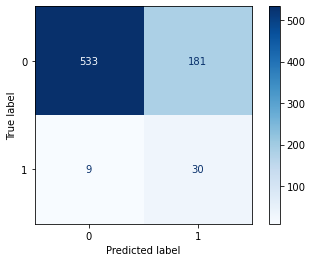

In [11]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

plot_confusion_matrix(LR_l2, X_test, Y_test, cmap=plt.cm.Blues)
plt.show()

#### Basic RF

In [12]:
from sklearn.ensemble import RandomForestClassifier

scoring = 'roc_auc'

AUC_RF = []
Recallvalue_RF = []
Accuracyvalue_RF = []

for trainkey, testkey in zip(StdTrain.keys(), StdTest.keys()):
    
    X_train = StdTrain[trainkey][predictorList]
    Y_train = StdTrain[trainkey]['FCSStaus']
    X_test = StdTest[testkey][predictorList]
    Y_test = StdTest[testkey]['FCSStaus']
    RF = RandomForestClassifier(n_estimators=800,n_jobs=-1,random_state=527, class_weight='balanced')
    grid_rf = {"min_samples_leaf":[100],'max_depth':[3, 5, 7]}
    crossval_rf = GridSearchCV(RF,grid_rf,cv=5,scoring=scoring)
    crossval_rf.fit(X_train, Y_train)
    RF2 = RandomForestClassifier(n_estimators=800,n_jobs=-1,random_state=527, 
                                class_weight='balanced', **crossval_rf.best_params_)
    grid_rf2 = {"min_samples_leaf":[200,100], 'max_features' : [5,7,9]}
    crossval_rf2 = GridSearchCV(RF2,grid_rf2,cv=5,scoring=scoring)
    crossval_rf2.fit(X_train, Y_train)
    RF3 = RandomForestClassifier(n_estimators=1000,n_jobs=-1,random_state=527, 
          max_depth = crossval_rf.best_params_['max_depth'], **crossval_rf2.best_params_, 
                            class_weight='balanced')
    RF3.fit(X_train, Y_train)
    y_RFpred_test = RF3.predict(X_test)
    y_RFpredProb_test = RF3.predict_proba(X_test)[:, 1]
    Recallvalue_RF.append(recall_score(Y_test, y_RFpred_test ))
    AUC_RF.append(roc_auc_score(Y_test, y_RFpredProb_test))
    Accuracyvalue_RF.append(accuracy_score(Y_test, y_RFpred_test))

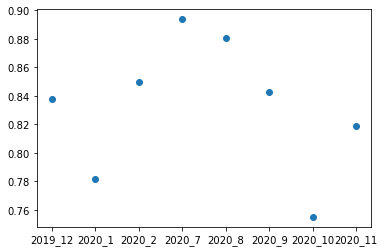

In [13]:
xaxis = ['2019_12','2020_1', '2020_2', '2020_7', '2020_8', '2020_9', '2020_10', '2020_11']
plt.scatter(xaxis, AUC_RF)


In [14]:
time_splitted_data_1920.keys()

dict_keys(['2019_9', '2019_10', '2019_11', '2019_12', '2020_1', '2020_2', '2020_7', '2020_8', '2020_9', '2020_10', '2020_11'])

#### Basic XGBoost

In [15]:
import xgboost as xgb # use xgb.cv 
from xgboost.sklearn import XGBClassifier
from sklearn import metrics 

In [16]:
AUC_xgb = []
Recallvalue_xgb = []
Accuracyvalue_xgb = []
for trainkey, testkey in zip(StdTrain.keys(), StdTest.keys()):
    X_train = StdTrain[trainkey][predictorList]
    Y_train = StdTrain[trainkey]['FCSStaus']
    X_test = StdTest[testkey][predictorList]
    Y_test = StdTest[testkey]['FCSStaus']
    class_weight = Y_train.value_counts()[0]/Y_train.value_counts()[1]
    DataTrain = pd.concat([X_train,Y_train],axis=1)
    param_test1 = {
    'max_depth':[3,5,7],
    'min_child_weight':range(1,10,3)
    }
    gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.05, n_estimators=800, max_depth=5,
    min_child_weight=1, gamma=1, reg_lambda = 100, subsample=0.8, colsample_bytree=0.8,
    objective= 'binary:logistic', nthread=4, scale_pos_weight= class_weight, seed=27), 
    param_grid = param_test1, scoring=scoring, n_jobs=-1, cv=5)
    gsearch1.fit(X_train,Y_train)
    param_test3 = {
    'gamma':[i/10.0 for i in range(5,21,5)]
    }
    gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.05, n_estimators=800, subsample=0.8, 
    colsample_bytree=0.8, **gsearch1.best_params_, 
    objective= 'binary:logistic', nthread=4, scale_pos_weight=class_weight,seed=27), 
    param_grid = param_test3, scoring=scoring, n_jobs=-1, cv=5)
    gsearch3.fit(X_train,Y_train)
    param_test4 = {
    'subsample':[i/10.0 for i in range(6,11,2)],
    'colsample_bytree':[i/10.0 for i in range(4,9,2)]
    }
    gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.05, n_estimators=800, 
    subsample=0.8, colsample_bytree=0.8, **gsearch3.best_params_, 
    objective= 'binary:logistic', nthread=4, scale_pos_weight=class_weight,seed=27), 
    param_grid = param_test4, scoring=scoring ,n_jobs=-1, cv=5)
    gsearch4.fit(X_train,Y_train)
    param_test6 = {'reg_lambda':[100,500,1000,1500]}
    gsearch6 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.05, n_estimators=800, **gsearch4.best_params_, 
    objective= 'binary:logistic', nthread=4, scale_pos_weight=class_weight,seed=27), 
    param_grid = param_test6, scoring=scoring , n_jobs=-1, cv=5)
    gsearch6.fit(X_train,Y_train)
    xgb4 = XGBClassifier( learning_rate =0.01, n_estimators=5000, **gsearch6.best_params_,
    objective= 'binary:logistic', nthread=4, scale_pos_weight=class_weight,seed=27)
    xgb_estimator, accuracy, auc, recall = XGBmodelfitTime(xgb4, DataTrain, predictorList, X_test=X_test, Y_test=Y_test)
    AUC_xgb.append(auc)
    Accuracyvalue_xgb.append(accuracy)
    Recallvalue_xgb.append(recall)
    

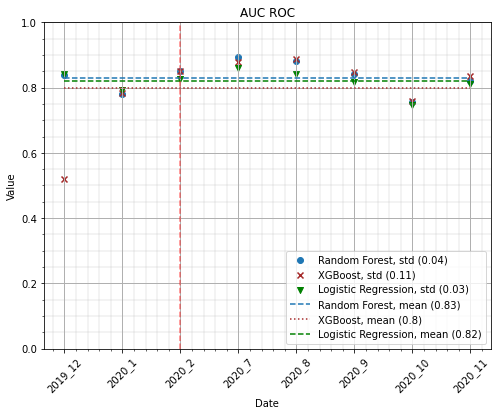

In [17]:
xaxis = ['2019_12','2020_1', '2020_2', '2020_7', '2020_8', '2020_9', '2020_10', '2020_11']
timeplot(xaxis, AUC_RF, AUC_xgb, AUC_LR, "./figures/TimeAUC.png", 'AUC ROC')

In [32]:
df = pd.DataFrame({"Time":xaxis, "AUC_RF":AUC_RF, "AUC_XGB":AUC_xgb, "AUC_LR":AUC_LR,
     "recall_RF":Recallvalue_RF, "recall_XGB":Recallvalue_xgb, "recall_LR":Recallvalue_LR ,
    "accuracy_RF":Accuracyvalue_RF, "accuracy_XGB":Accuracyvalue_xgb, "accuracy_LR":Accuracyvalue_LR })
df.to_csv("TimeSeriesResults.csv", index=False)

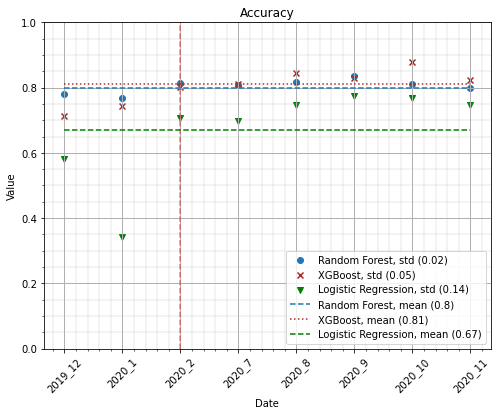

In [18]:
timeplot(xaxis, Accuracyvalue_RF, Accuracyvalue_xgb, Accuracyvalue_LR, "./figures/TimeAccuracy.png", 
         'Accuracy')

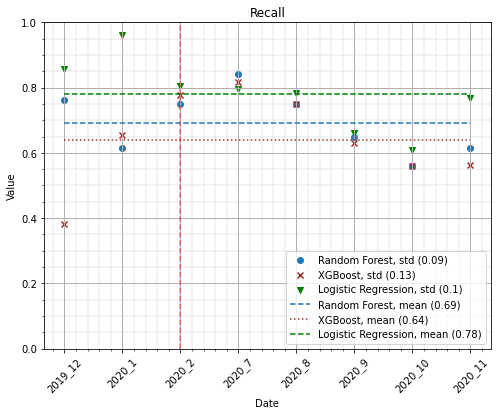

In [19]:
timeplot(xaxis, Recallvalue_RF, Recallvalue_xgb, Recallvalue_LR, "./figures/TimeRecall.png", 
         'Recall')

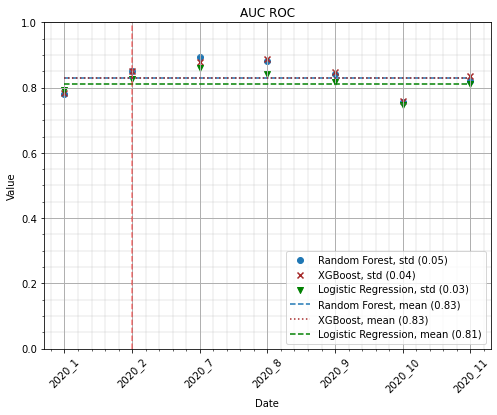

In [20]:
xaxis = ['2019_12','2020_1', '2020_2', '2020_7', '2020_8', '2020_9', '2020_10', '2020_11']
timeplot(xaxis[1:], AUC_RF[1:], AUC_xgb[1:], AUC_LR[1:], "./figures/TimeAUC_1.png", 'AUC ROC')

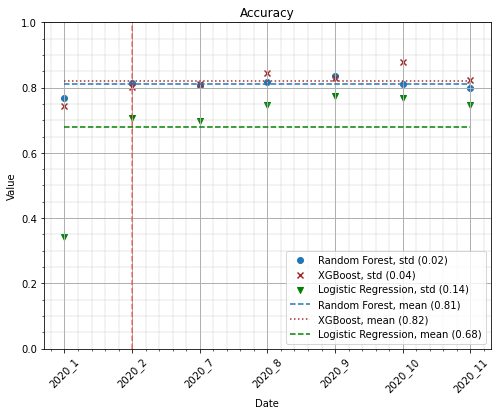

In [21]:
timeplot(xaxis[1:], Accuracyvalue_RF[1:], Accuracyvalue_xgb[1:], Accuracyvalue_LR[1:], "./figures/TimeAccuracy_1.png", 
         'Accuracy')

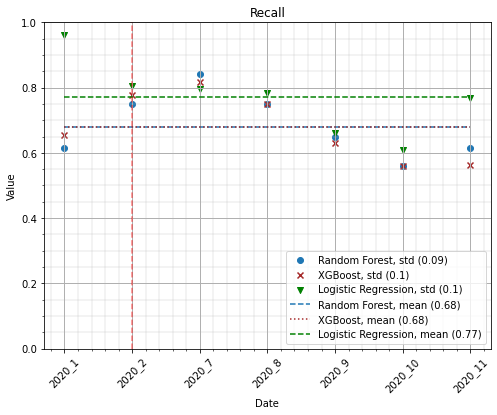

In [22]:
timeplot(xaxis[1:], Recallvalue_RF[1:], Recallvalue_xgb[1:], Recallvalue_LR[1:], "./figures/TimeRecall_1.png", 
         'Recall')

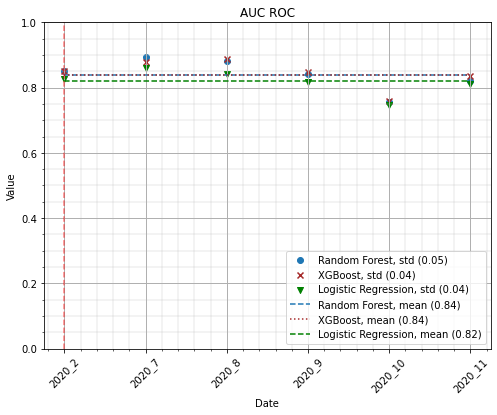

In [23]:
xaxis = ['2019_12','2020_1', '2020_2', '2020_7', '2020_8', '2020_9', '2020_10', '2020_11']
timeplot(xaxis[2:], AUC_RF[2:], AUC_xgb[2:], AUC_LR[2:], "./figures/TimeAUC_2.png", 'AUC ROC')

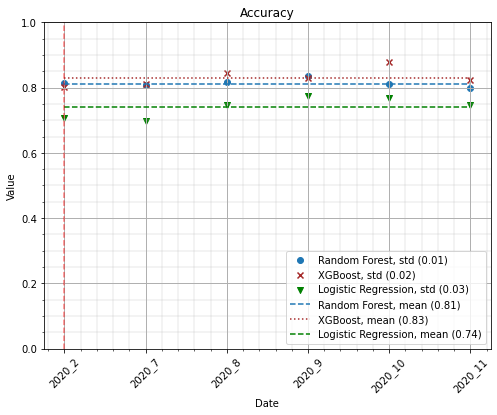

In [24]:
timeplot(xaxis[2:], Accuracyvalue_RF[2:], Accuracyvalue_xgb[2:], Accuracyvalue_LR[2:], "./figures/TimeAccuracy_2.png", 
         'Accuracy')

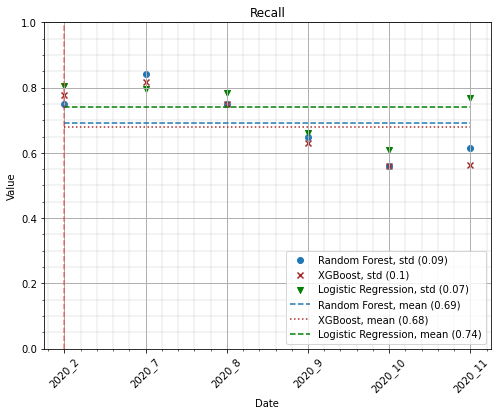

In [25]:
timeplot(xaxis[2:], Recallvalue_RF[2:], Recallvalue_xgb[2:], Recallvalue_LR[2:], "./figures/TimeRecall_2.png", 
         'Recall')

In [ ]:
corr_matrix = StdTrain['train_9'][['SubjectivePoverty_Very poor','ValueAgoTotal_new', 
         'valueNow_Furniture', 'RelLivStandard_Worse off', 
         'SelfStapleTypes', 'Salt_Yes', 'MaleRatio', 'FamilySize',
         'AvgAge', 'valueNow_MobilePhone']].corr()
# Plot heatmap
plt.figure(figsize=(20, 10))  # Set the size of the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Coefficient Heatmap')
plt.savefig("./figures/Corre_Coef_resamp.png")

In [ ]:
predictorList_new = ['SubjectivePoverty_Very poor','ValueAgoTotal_new', 
         'valueNow_Furniture', 'RelLivStandard_Worse off', 
         'SelfStapleTypes', 'Salt_Yes', 'MaleRatio', 'FamilySize',
         'AvgAge', 'valueNow_MobilePhone']

binaryList_using = list(set(binaryList) & set(predictorList_new))
freq = ['HouseType', 'RoofType', 'WaterSource']
freqList = [f"{i}_feq" for i in freq]
freqList_using = list(set(freqList) & set(predictorList_new))
nonstdList_using = list(set(nonstdList) & set(predictorList_new))
standardizationList_using = list(set(predictorList_new) - set(binaryList_using) - set(freqList_using) - set(nonstdList_using))

In [ ]:
X_train_org = StdTrain['train_9'][predictorList_new]
Y_train_org = StdTrain['train_9']['FCSStaus']

X_test_org = StdTest['test_9'][predictorList_new]
Y_test_org = StdTest['test_9']['FCSStaus']

X_train_org.reset_index(drop=True,inplace=True)
X_test_org.reset_index(drop=True,inplace=True)
Y_train_org.reset_index(drop=True,inplace=True)
Y_test_org.reset_index(drop=True,inplace=True)

X_smote, Y_smote, X_ADA, Y_ADA = resampling(X_train_org, Y_train_org)

print(X_smote.shape, Y_smote.shape, X_test_org.shape, Y_test_org.shape)